##### Daily closing price of Microsoft stock (MSFT)

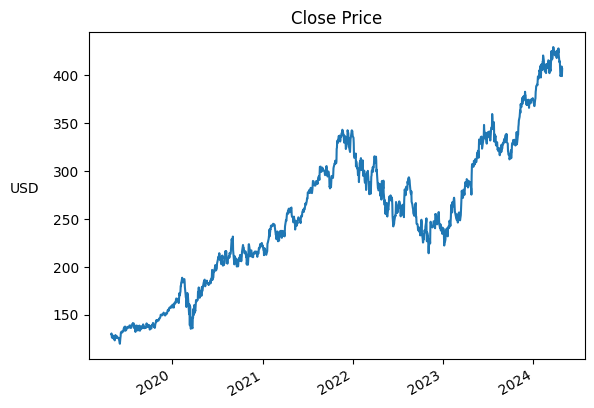

In [1]:
import pandas as pd
df = pd.read_csv('../data/msft-historical.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
pdx = '20211004'
ax = df['Close'][:].plot(title='Close Price', xlabel='')
_ = ax.set_ylabel('USD', rotation=0, labelpad=20)

Time series analysis assumes stationary data i.e. data that does not follow a long-term trend (i.e. has constant mean over time), is not volatile (i.e. has constant variance and autocorrelation over time) and does not exhibit seasonality (i.e. does not follow periodic patterns).

The `STL` method uses LOESS (locally estimated scatterplot smoothing) to capture the trend and seasonal components of a time series.<br>
What's left out of the trend and seasonal componenets is called the residual.<br>
Alternatively we can use differencing. First-order differencing is usually sufficient for capturing correlations in the data.<br>
We can further tune models to capture whatever correlation is left in the STL residual or the differenced data.<br>

##### STL parameters
`season` determines the smoothness (rate of change) of the seasonal component. Must be odd and larger than 6.<br>
`trend` determines the smoothness of the trend component. Usually 1.5x the `season`. Must be odd and larger than `season`.<br>
`low_pass` is the length of the low-pass estimation window. Usually the smallest odd number larger than the period.<br>
The `robust`, `seasonal_deg` and `trend_deg` parameters determine how aggressively the model captures outliers in the trend and seasonal componenets.

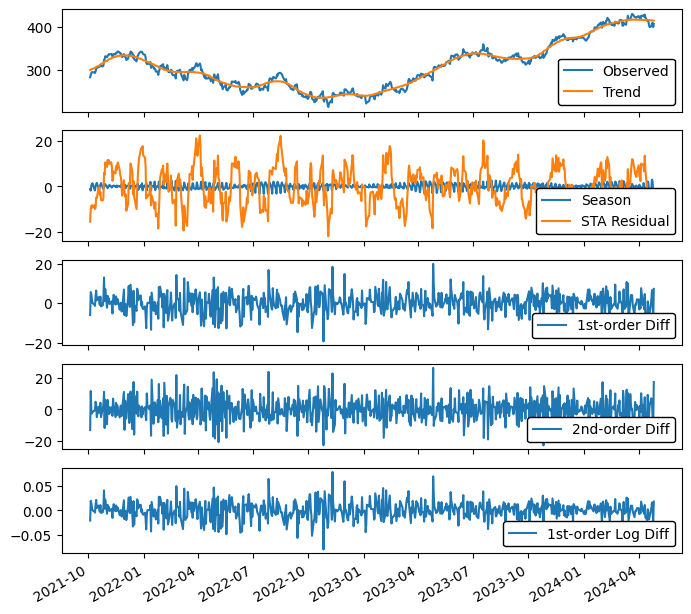

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import STL
# Set the period to Business Week.
df = df.asfreq('B')
df = df.fillna(df.interpolate())
# Apply differencing and trim the NaNs.
diff1 = df['Close'].diff()[10:]
diff2 = df['Close'].diff().diff()[10:]
log_close = np.log(df['Close'])
log_diff1 = log_close.diff()[10:]
log_diff2 = log_close.diff().diff()[10:]
df_close = df['Close'][10:]
log_close = log_close[10:]
# Decompose the original series using STL.
stl = STL(df_close, trend=61, seasonal=15).fit()
stl.resid.name = 'STA Residual'
diff1.name = '1st-order Diff'
diff2.name = '2nd-order Diff'
log_diff1.name = '1st-order Log Diff'
log_diff2.name = '2nd-order Log Diff'
df_close.name = 'Observed'
# Plot
fig, axs = plt.subplots(5, sharex=True, figsize=(8, 8), height_ratios=[1.2, 1.3, 1, 1, 1])
axs[0].plot(df_close[pdx:], label=df_close.name)
axs[0].plot(stl.trend[pdx:], label=stl.trend.name.capitalize())
axs[1].plot(stl.seasonal[pdx:], label=stl.seasonal.name.capitalize())
axs[1].plot(stl.resid[pdx:], label=stl.resid.name)
axs[2].plot(diff1[pdx:], label=diff1.name)
axs[3].plot(diff2[pdx:], label=diff2.name)
# The difference of the natural log is equivilant to the percent change.
axs[4].plot(log_diff1[pdx:], label=log_diff1.name)
[ax.legend(fontsize=10, loc='lower right', edgecolor='black', framealpha=1) for ax in axs]
fig.autofmt_xdate()

Stationarity can be measured with the Augmented Dickey–Fuller test.

In [3]:
from tabulate import tabulate
from statsmodels.tsa.stattools import adfuller
from pprint import pprint
adf_close = adfuller(df_close)
adf_resid = adfuller(stl.resid)
adf_diff1 = adfuller(diff1)
adf_diff2 = adfuller(diff2)
adf_log_diff1 = adfuller(log_diff1)
adf_log_diff2 = adfuller(log_diff2)
table = (
    ('Observed', adf_close[1], adf_close[0]),
    ('STA Residual', adf_resid[1], adf_resid[0]),
    ('1st-order Diff', adf_diff1[1], adf_diff1[0]),
    ('2nd-order Diff', adf_diff2[1], adf_diff2[0]),
    ('1st-order Log Diff', adf_log_diff1[1], adf_log_diff1[0]),
    ('2nd-order Log Diff', adf_log_diff2[1], adf_log_diff2[0]))
print('\nAdfuller Results')
print(tabulate(table, headers=('Series', 'p-value', 'Test Stat'), stralign='center', numalign='center', tablefmt='fancy_grid'))
print('Critical Values')
pprint(adf_close[4])


Adfuller Results
╒════════════════════╤═════════════╤═════════════╕
│       Series       │   p-value   │  Test Stat  │
╞════════════════════╪═════════════╪═════════════╡
│      Observed      │  0.855728   │  -0.664516  │
├────────────────────┼─────────────┼─────────────┤
│    STA Residual    │ 1.29449e-17 │  -10.0662   │
├────────────────────┼─────────────┼─────────────┤
│   1st-order Diff   │ 5.3065e-21  │  -11.4696   │
├────────────────────┼─────────────┼─────────────┤
│   2nd-order Diff   │ 4.27707e-24 │  -12.8995   │
├────────────────────┼─────────────┼─────────────┤
│ 1st-order Log Diff │ 2.55691e-20 │  -11.1769   │
├────────────────────┼─────────────┼─────────────┤
│ 2nd-order Log Diff │ 1.66246e-25 │  -13.6397   │
╘════════════════════╧═════════════╧═════════════╛
Critical Values
{'1%': -3.4354531319230373,
 '10%': -2.5679698346531965,
 '5%': -2.8637935995282224}


A low p-value, typically smaller than 0.05, indicates statistical significance of the test result by rejecting the null hypothesis.<br>
in other words, the smaller the p-value, the less likely the test-statistic is a fluke.<br>
For an Adfuller test, a test statistic more negative than a critical value indicates stationarity. Critical values are typically chosen for significance levels of 1%, 5% and 10%.<br>
E.g. a test statistic more negative than the critical value at 1%-significance indicates that the data is 99% likely to be stationary.<br>
In simpler terms, we can conclude stationarity if the p-value is lower than 0.05 and the test statistic is more negative than the critical value at either 1% or 5%.

We can see that observed data is far from stationary. On the other hand the STA residual, the differenced observed values and the differenced logs of the observed values pass the test for stationarity.<br>

##### ARMA (autoregressive moving-average) is a time-series forecasting model with two parameters.
The autoregressive component p is the number of previous data points to factor into the next prediction.<br>
The moving-average component q is the number of previous prediction errors to factor into the next prediction.<br>
The ARMA equation is a weighted sum of one or more of these past values and errors, plus a constant.<br>
We can acquire candidate lists for p and q thorugh descriptive analysis of the partial autocorrelation (PACF) and the autocorrelation (ACF) of the stationary series.

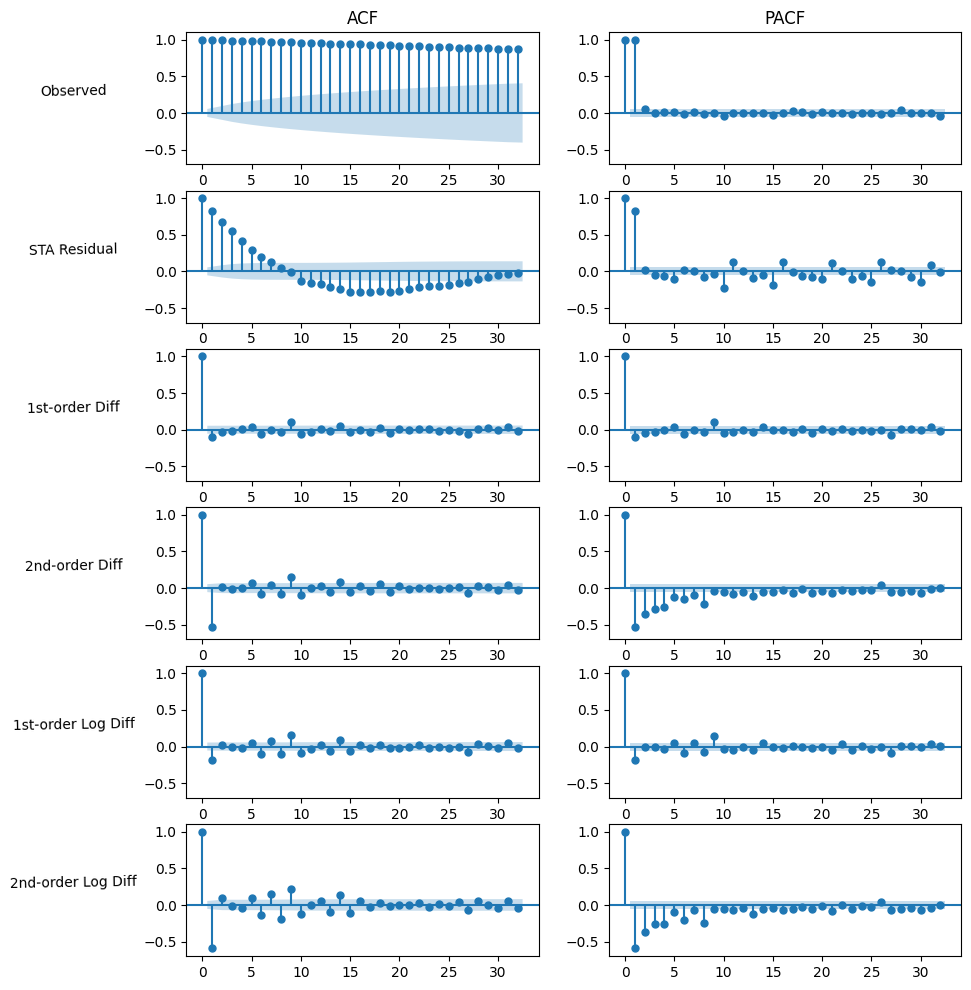

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(10, 12))
for i, data in enumerate([df_close, stl.resid, diff1, diff2, log_diff1, log_diff2]):
    axs[i][0].set_ylabel(data.name, rotation=1, labelpad=50)
    [plot(data, ax=axs[i,j], title='') for j, plot in enumerate([plot_acf, plot_pacf])]
axs[0][0].set_title('ACF')
axs[0][1].set_title('PACF')
plt.setp(axs, ylim=(-0.70, 1.1))
plt.show()

The plots show the correlation between an observation and its past values. The x-axis is the number of time steps into the past, called lags.<br>
ACF is accumulative e.g) if 2 correlates with 1, and 1 correlates with 0, that means 2 will correlate with 0 by propagation.<br>
PACF captures direct correlation only by excluding these intermediate effects.<br>
The shaded area is the confidence interval. Any correlation outside the confidence interval is statistically significant.<br>
Correlation at lag 0 is redundant since a data point naturally correlates with itself.

If **PACF** cuts off (sharply transitions from significant to insignificant) at lag k (especially while ACF decays gradually i.e. has significant spikes at higher lags), this is called an **AR signature**.<br> It is commonly associated with a positive autocorrelation at lag 1 and tends to arise when the series is slightly underdifferenced. This signature suggests k AR terms be used in the forecasting equation, *as AR terms introduce partial differencing to the forecasting equation.*<br>
If **ACF** cuts off at lag k (especially while PACF decays gradually), this is called an **MA signature**. It is commonly associated with a negative autocorrelation at lag 1 and tends to arise when the series is slightly overdifferenced. This signature suggests k MA terms be used in the forecasting equation, *as MA terms partially cancel differencing in the forecasting equation.*

The observed values and the STA residual have significant ACF at low-order lags (<5) decaying slowly over large lags (>20). These are indicators of strongly-trended non-stationary series.<br>
The 1st-order difference has small and patternless autocorrelations. This indicates sufficient differencing. Another indication of a sufficiently differenced series is when the lag-1 autocorrelation is zero or slightly negative.<br>
The 2nd-order difference shows a strong negative autocorrelation at lag 1, which indicates overdifferencing.

Inspecting the ACF/PACF plots of 1st-order and 2nd-order diffs, we identify significant autocorrelation at lags 1, 6 and 9. For most data, the best models usually have either p oe q set zero, with p+q being smaller than 3. We therefore add the values 2 and 3 to our candidate list for p and q making it [0, 1, 2, 3, 6, 9]. For d, we sweep over values 1 and 2 (1st and 2nd order differencing respectively) as well as 0 (no differencing) for completeness i.e. [0, 1, 2].

At first we will focus on comparing non-seasonal models.<br>
Later on we will sweep over the seasonal parameters P, D and Q for a period s = 5 to attempt to capture weekly seasonality.<br>
We will also use STL with varying smoothness and outlier robustness factors to extract and separately process the trend and seasonality components.

Aside from simplicity, we do a grid sweep because it is possible for AR terms and MA terms to cancel each other out. Also, a different order of differencing can become more suitable as AR or MA terms are added. Lastly, it's possible for an AR signature to benefit more from MA terms and vice versa.

In [5]:
import statsmodels.api as sm
alpha = 0.05
num_lags = 30
grid_depth = 10
for data in [diff1, diff2]:
    print('\n', data.name)
    for acf in [sm.tsa.acf, sm.tsa.pacf]:
        acf_values, confidence_interval = acf(data, nlags=num_lags, alpha=alpha)
        lower_bounds = confidence_interval[:, 0]
        upper_bounds = confidence_interval[:, 1]
        lags = [(i, acf_values[i], abs(upper_bounds[i])) for i in range(1, num_lags+1) if upper_bounds[i] < 0]
        lags += [(i, acf_values[i], lower_bounds[i]) for i in range(1, num_lags+1) if lower_bounds[i] > 0]
        lags = sorted(lags, key=lambda x: x[2], reverse=True)[:grid_depth]
        print(tabulate(lags, headers=('Lag', (acf.__name__[:-1]+'r').upper(), 'Distance'), tablefmt='outline'))


 1st-order Diff
+-------+------------+------------+
|   Lag |        ACR |   Distance |
+=======+============+============+
|     9 |  0.112393  | 0.0569416  |
|     1 | -0.098564  | 0.0440996  |
|     6 | -0.0629241 | 0.00774481 |
|    27 | -0.0642474 | 0.00740216 |
|    10 | -0.0611752 | 0.00505258 |
|    14 |  0.0576027 | 0.00120619 |
+-------+------------+------------+
+-------+------------+-------------+
|   Lag |       PACR |    Distance |
+=======+============+=============+
|     9 |  0.104574  | 0.0501096   |
|     1 | -0.0986402 | 0.0441758   |
|    27 | -0.0793632 | 0.0248988   |
|     6 | -0.0550368 | 0.000572348 |
+-------+------------+-------------+

 2nd-order Diff
+-------+------------+------------+
|   Lag |        ACR |   Distance |
+=======+============+============+
|     1 | -0.527793  | 0.473328   |
|     9 |  0.146426  | 0.0776014  |
|    10 | -0.0937846 | 0.0240416  |
|     8 | -0.0831918 | 0.0146657  |
|     6 | -0.0781992 | 0.0100304  |
|    14 |  0.0778386 |

Following further examination of the ACF/PACF values falling outside the confidence interval, we decide to extend the sweep range of non-seasonal p and q to **1** -> **10** inclusive.<br>
Before we start collecting results, we will first run through an example for a model of order (10, 0, 0).

                               SARIMAX Results                                
Dep. Variable:               Observed   No. Observations:                 1035
Model:                ARIMA(10, 1, 0)   Log Likelihood               -2985.284
Date:                Sat, 25 May 2024   AIC                           5994.568
Time:                        22:53:11   BIC                           6053.862
Sample:                    05-13-2019   HQIC                          6017.067
                         - 04-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1762      0.122      1.446      0.148      -0.063       0.415
ar.L1         -0.0780      0.024     -3.221      0.001      -0.126      -0.031
ar.L2         -0.0335      0.025     -1.328      0.1

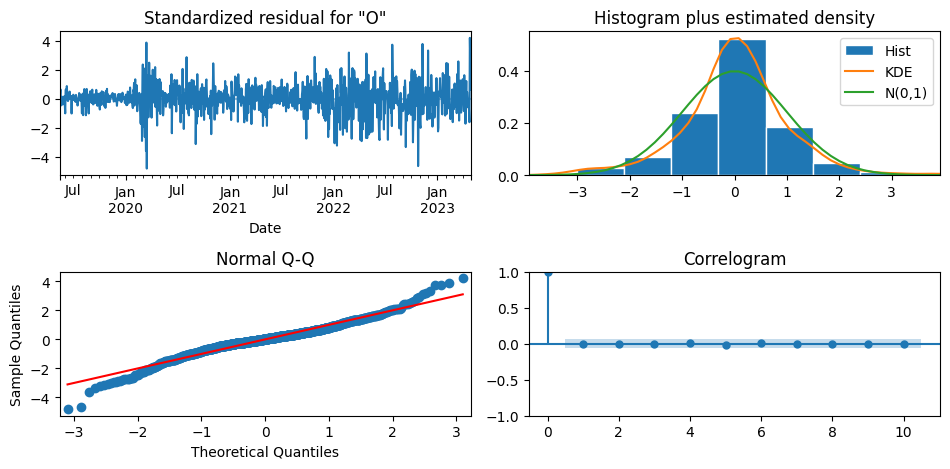

In [6]:
from statsmodels.tsa.arima.model import ARIMA
# Split the data into train and test subsets.
# The train data is used to fit the model.
# The test data is used to assess the accuracy of the forecasts.
data= df_close
train = data[:'20230428']
test = data['20230501':]
order = (10,1,0)
# The trend parameter controls the deterministic trend: ‘c’ for constant, ‘t’ for linear trend, ‘ct’ for both.
# 'c' and 'ct' can only be used when d = 0. 't' can be used when d <= 1. Setting the trend parameter is not allowed for d >= 2.
trend = 't'
model = ARIMA(
    train,
    order=order,
    trend=trend,
    seasonal_order=(0,0,0,0)
).fit()
print(model.summary())
model.plot_diagnostics(figsize=(9.6,4.8))
plt.tight_layout()
plt.show()

- The residuals are centered around a zero mean and do not appear to follow a pattern.<br>
- The residuals display some heteroscedasticity i.e. their variance changes over time. There is a noticeable increase in variance beginning on Septemeber-2022 as the stock price becomes more volatile. We will later look at ways to mitigate this e.g. by transforming the original series, by varying the train series length, and by processing the trend/seasonal/residual components separately.<br>
- The Jarque-Bera test strongly indicates non-normality, mostly as a result of positive kurtosis. The sharper KDE peak means more residual values are concentrated around the zero mean. While this generally means the model is a good fit, it could also be a sign of overfitting. Consequently, both tails are thinner than their standard normal counterparts.<br>
- The small positive skew, and a thinner left tail compared to the right, indicates the model is more likely to overpredit than underpredict. We can contextually associate overprediction with price dips and underprediction with spikes in price. The "fattening" of the far end of the left tail suggests a higher-than-normal probability of gross overprediction.<br>
- There are no significant autocorrelations in the first 10 lags, wich means the model does a good job fitting autocorrelations from the last two business weeks. This is supported by the Ljung-Box test results.<br>
- There is no unit root in the AR part of the model i.e. the sum of AR coefficients is not close to 1, implying adequate differencing. The z-statistics (coeff/stderr) and their p-values show the 1st and 9th coefficientes are the most significant followed by 6 and 10,  aligning with the ACR/PACR analysis.
- AIC and BIC evaluate the goodness of fit of the model while penalizing complexity i.e. the number of coefficients. Lower values indicate a better fit. We will not pay much attention to these criteria since we are not currently constrained by time or performance. (1. The original series is not large. 2. We refit the model once a day or once a week. 3. We make one prediction a day).<br>

Predictions can be made in-sample or out-of-sample (the sample being the training data used to fit the model).<br>
Non-dynamic predictions made in-sample are a recalculation of the fitted points i.e. they are identical to `model.fittedvalues`<br>
Dynamic predictions (whether in-sample or out-of-sample) use previous predictions rather than previous observations. The further out the forecast horizon, the more the model relies on previous predictions than previous observations. This leads to predictions converging to the mean or trend line especially if there are no significant patterns captured by the AR or MA terms. ARIMA models are generally inadequate for long-term predictions.

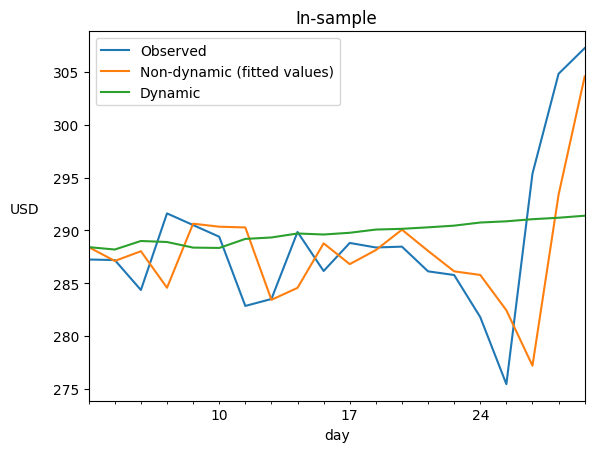

In [7]:
num = 20
observed = train[-num:]
observed.name = 'Observed'
fitted = model.predict(start=train.index[-num], end=train.index[-1])
fitted.name = 'Non-dynamic (fitted values)'
dynamic = model.predict(start=train.index[-num], end=train.index[-1], dynamic=True)
dynamic.name = 'Dynamic'
results = pd.concat([observed, fitted, dynamic], axis=1)
ax = results.plot(title='In-sample', xlabel='day', xticks=[])
ax.set_ylabel('USD', rotation=0, labelpad=20)
plt.show()

Predictions made out of sample are called forecasts. Forecasts are dynamic by default as there are no observed values beyond the train series. Dynamic forecasting is relevant in applications where observations become available at a lower rate than making forecasts. When observed values become available, they can be appended to the model for use in future forecasts. This makes for non-dynamic forecasting despite it being made out-of-sample. The model itself can be refitted with the most recent observations, in which case the coefficients of the forecast equation are recalculated. The terminology and some ARIMA class methods can become redundant with how we view the original series (i.e. whether it is explicitly split into train and test data) as well as the forecasting strategy used.

In this example we make non-dynamic out-of-sample forecasts i.e. starting from the tail of the train series. The test series remains hidden from the model. Following a forecast, its corresponding observation is appended to the model, making it available for use in the next forecast.<br>
We compare 3 refitting strategies: Daily vs. Weekly vs. No refitting<br>
**Note**: Fitting the model makes up the majority of the compute overhead.

In [8]:
import time
len_test = len(test)
test = test[:len_test]
results = test
for s in ['Append', 'Refit-daily', 'Refit-weekly']:
    start = time.time()
    forecasts = []
    model = ARIMA(
        train,
        order=order,
        trend=trend,
    ).fit()
    for i in range(1, len_test+1):
        print('{}{}{}/{}'.format(s, ' '*(13-len(s)), i, len_test), end='\r')
        refit = s == 'Refit-daily' or s == 'Refit-weekly' and not i % 5
        forecasts.append(model.forecast(1))
        model = model.append(test[forecasts[-1].index], refit=refit)
    # print()
    forecasts = pd.concat(forecasts)
    forecasts.name = s
    results = pd.concat([results, forecasts], axis=1)
    end = time.time()
    print('{}{}{}/{}{}{} seconds elapsed'.format(s, ' '*(13-len(s)), len_test, len_test, ' '*3, int(end-start)))
# results.rename(columns={'Close': 'Observed'}, inplace=True)

Append       260/260   39 seconds elapsed
Refit-daily  260/260   218 seconds elapsed
Refit-weekly 260/260   82 seconds elapsed


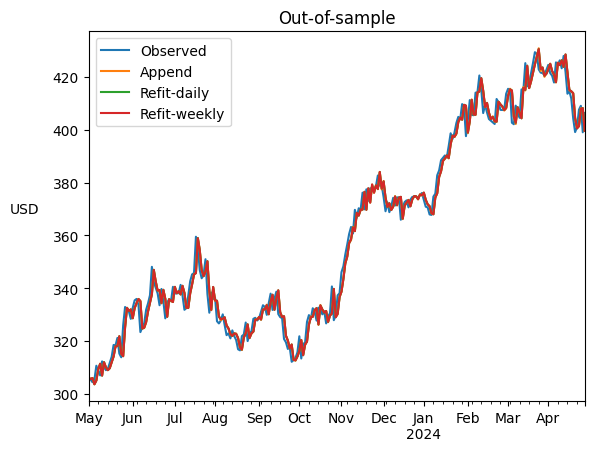

              Observed      Append  Refit-daily  Refit-weekly
2023-05-01  305.559998  306.158700   306.158700    306.158700
2023-05-02  305.410004  305.571127   305.565744    305.571127
2023-05-03  304.399994  306.003514   306.003765    306.003514
2023-05-04  305.410004  303.637439   303.626829    303.637439
2023-05-05  310.649994  305.040457   305.061289    305.040457
...                ...         ...          ...           ...
2024-04-22  400.959991  400.722599   400.516914    400.516933
2024-04-23  407.570007  401.338649   401.359813    401.357771
2024-04-24  409.059998  408.099985   407.930677    407.902715
2024-04-25  399.040009  408.238440   408.188597    408.175540
2024-04-26  406.320007  399.547266   399.578247    399.606024

[260 rows x 4 columns]


In [9]:
ax = results.plot(title='Out-of-sample')
ax.set_ylabel('USD', rotation=0, labelpad=20)
plt.show()
print(results)

The refitting strategies produced nearly identical results. Since we will be using the same test data to compare models, it is safe to forego refitting from this point on.<br>
We can see that forecasts follow the observed values, as each forecast is calculated from its 10 preceeding observations.<br>

We perform a gird sweep over the model parameters, fit the models using the train series and save the model statistics (sorted by AIC) in a file.

In [11]:
import json
import warnings
warnings.filterwarnings("error")
wf = open('../output/warnings.txt', 'w')
# Sweep range for p and q
pq = 11
# Sweep range for d and trend
dt = (
    (0, [None, 'c', 'ct', 't']),
    (1, [None, 't']),
    (2, [None])
)
num = sum(len(x[1]) for x in dt)*pq**2
# Grid Sweep
cnt = 0
models = []
start = time.time()
for d in dt:
    for t in d[1]:
        for p in range(pq):
            for q in range(pq):
                # print(p, d[0], q, t)
                try:
                    cnt += 1
                    print('{}/{}'.format(cnt, num), end='\r')
                    model = ARIMA(
                        train,
                        trend=t,
                        order=(p, d[0], q)
                    ).fit()
                    adf = adfuller(model.resid)
                    model_summary = {
                        "model": {'p':p,'d':d[0],'q':q,'trend':t},
                        "coefficients": {
                            "coef": model.params.to_dict(),
                            "z_values": model.zvalues.tolist(),
                            "p_values": model.pvalues.tolist()
                        },
                        "aic": model.aic,
                        "bic": model.bic,
                        "adf": {
                            "statistic": adf[0],
                            "p_value": adf[1],
                            "critical_values": adf[4]
                        },
                        "summary": str(model.summary())
                    }
                    models.append(model_summary)
                except Exception as w:
                    wf.write('{}: {}\n'.format((p, d[0], q, t), w))
end = time.time()
models.sort(key=lambda x: x['aic'])
with open('../output/model.json', 'w') as f:
    json.dump(models, f, indent=4)
wf.close()
print("{}/{} models fitted\n{} warnings\n{} seconds elapsed".format(len(models), num, num-len(models), int(end-start)))

350/847 models fitted
497 warnings
1277 seconds elapsed


In [93]:
results = results_dynamic = test
with open('../output/model.json', 'r') as mf:
    models = json.load(mf)
# Run a finite number of models with the highest AIC
models = models[:50]
pad = len(str(len_test*2))
start = time.time()
for i, m in enumerate(models):
    p = m['model']['p']
    d = m['model']['d']
    q = m['model']['q']
    t = m['model']['trend']
    # Daily forecasts
    model = ARIMA(
        train,
        order=(p,d,q),
        trend=t
    ).fit()
    forecasts = []
    for j in range(1, len_test+1):
        print('{}/{} {}/{}'.format(i+1, len(models), str(j+1).zfill(pad), len_test*2), end='\r')
        forecasts.append(model.forecast(1))
        model = model.append(test[forecasts[-1].index], refit=False)
    forecasts = pd.concat(forecasts)
    forecasts.name = f'{p},{d},{q}+{t}'
    results = pd.concat([results, forecasts], axis=1)
    # Weekly forecasts
    model = ARIMA(
        train,
        order=(p,d,q),
        trend=t
    ).fit()
    forecasts = []
    for w in range(1, len_test+1, 5):
        print('{}/{} {}/{}'.format(i+1, len(models), str(w+j+1).zfill(pad), len_test*2), end='\r')
        forecasts.append(model.forecast(5))
        model = model.append(test[forecasts[-1].index], refit=False)
    forecasts = pd.concat(forecasts)
    forecasts.name = f'{p},{d},{q}+{t}'
    results_dynamic = pd.concat([results_dynamic, forecasts], axis=1)
print('{}/{} {}/{}'.format(i+1, len(models), len_test*2, len_test*2), end='\r')
end = time.time()
results.index.name = 'Date'
results_dynamic.index.name = 'Date'
results.to_csv('../output/results.csv', sep=',')
results_dynamic.to_csv('../output/results_dynamic.csv', sep=',')
print("\n{} seconds elapsed".format(int(end-start)))

50/50 520/520
2011 seconds elapsed
